Some of this code, particularly the window generator functions, has been pulled from a very helpful TensorFlow turotial. This is the citation below.

“Time Series Forecasting  :  Tensorflow Core.” TensorFlow, 15 Dec. 2022, www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Data Pre-processing**


In [2]:
df = pd.read_csv('/content/HW_cluster0_rework.csv')

In [ ]:
df

In [ ]:
df['Heatwave'].value_counts()

In [ ]:
df0.describe().transpose()

In [3]:
df = df.sort_values(by ='time')

Creation of training, validation, and testing sets

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Creation of balanced training set for curriculum learning

In [ ]:
balanced_train = pd.DataFrame()

In [ ]:

for ii in range(30,len(train_df)-60,60):
  next_30 = train_df.iloc[ii:ii+30]
  next_30 = next_30[next_30["Heatwave"] == 1]
  if (next_30.empty == False):
      balanced_train = pd.concat([balanced_train,train_df.iloc[ii-30:ii+30]])



In [ ]:
balanced_train['Heatwave'].value_counts()

In [ ]:
train_df = balanced_train

Set up for scaling the data with normalization

In [5]:
time_col = train_df.pop('time')
time_col_v = val_df.pop('time')
time_col_ts = test_df.pop('time')
time_col_or = df.pop('time')



In [6]:
month_col_train = train_df.pop('month_y')
month_col_val = val_df.pop('month_y')
month_col_test = test_df.pop('month_y')
month_col = df.pop('month_y')

In [7]:
iso_col_train = train_df.pop('isobaricInhPa')
iso_col_val = val_df.pop('isobaricInhPa')
iso_col_test = test_df.pop('isobaricInhPa')
iso_col = df.pop('isobaricInhPa')

In [8]:
h_col_train = train_df.pop('Heatwave')
h_col_val = val_df.pop('Heatwave')
h_col_test = test_df.pop('Heatwave')
h_col = df.pop('Heatwave')

Normalizing the data

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

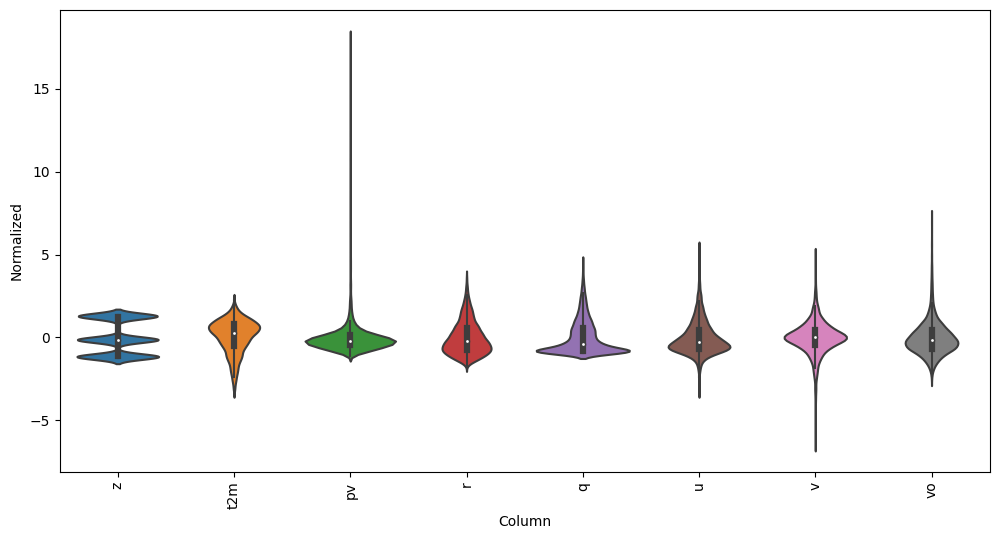

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [11]:
train_df['isobaricInhPa'] = iso_col_train
val_df['isobaricInhPa'] = iso_col_val
test_df['isobaricInhPa'] = iso_col_test

In [12]:
train_df['Heatwave'] = h_col_train
val_df['Heatwave'] = h_col_val
test_df['Heatwave'] = h_col_test

In [13]:
train_df['month_y'] = month_col_train
val_df['month_y'] = month_col_val
test_df['month_y'] = month_col_test

**Creation of windows**

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]



  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Heatwave', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('year_y')

WindowGenerator.plot = plot

# Convert to tf.data.dataset

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=5,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Models


Creation of window: looking at past 10 days of data to predict next 10 days heatwave values

In [ ]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Heatwave']
                               )

multi_window.plot()
multi_window

Have to set number of features to 1

In [20]:
num_features = 1

Convolutional model

In [21]:
CONV_WIDTH = 30
binary_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(550, activation='sigmoid', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.GlorotUniform()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

                            



binary_conv_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
                          metrics=[tf.keras.metrics.Recall(),'acc'])



Training step

In [ ]:
history = binary_conv_model.fit(multi_window.train, epochs=20,
                      validation_data=multi_window.val
                      )


Checking performance on testing set

In [23]:
performance = {}
performance['binary_conv_model'] = binary_conv_model.evaluate(multi_window.test, verbose=2)

134/134 - 1s - loss: 7.5690 - recall: 0.2005 - acc: 0.5081 - 948ms/epoch - 7ms/step


RNN (LSTM) model

In [24]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.GlorotUniform()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

multi_lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
                          metrics=[tf.keras.metrics.Recall(),'acc'])

Training step

In [ ]:
history = multi_lstm_model.fit(multi_window.train, epochs=20,validation_data=multi_window.val)

Checking performance on testing set

In [26]:
performance = {}
performance['multi_lstm_model'] = multi_lstm_model.evaluate(multi_window.test, verbose=2)

134/134 - 1s - loss: 7.5183 - recall_1: 0.1359 - acc: 0.5118 - 984ms/epoch - 7ms/step
